<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Simulating-some-data" data-toc-modified-id="Simulating-some-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Simulating some data</a></span><ul class="toc-item"><li><span><a href="#Simulating-Sentinel2-data" data-toc-modified-id="Simulating-Sentinel2-data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Simulating Sentinel2 data</a></span></li></ul></li><li><span><a href="#Retrieving-parameters:-fun-for-the-whole-family" data-toc-modified-id="Retrieving-parameters:-fun-for-the-whole-family-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Retrieving parameters: fun for the whole family</a></span></li><li><span><a href="#Being-a-bit-more-realistic" data-toc-modified-id="Being-a-bit-more-realistic-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Being a bit more realistic</a></span><ul class="toc-item"><li><span><a href="#The-model-is-wrong" data-toc-modified-id="The-model-is-wrong-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>The model is wrong</a></span></li><li><span><a href="#Wrong-statistical-model" data-toc-modified-id="Wrong-statistical-model-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Wrong statistical model</a></span></li></ul></li><li><span><a href="#What-have-we-learned" data-toc-modified-id="What-have-we-learned-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>What have we learned</a></span></li></ul></div>

<div style="float:right">
    <table>
    <tr>
        <td> <img src="figs/nceo_logo.png" alt="Drawing" style="width:200px;height:40px;"/> 
        <td> <img src="figs/multiply_logo.png" alt="Drawing" style="width:40px;height:40px;"/>
    </tr>
    </table>
</div>

# A simple inverse problem in Earth Observation

The PROSPECT+SAIL models have been used tons of times to retrieve biophysical parameters from optical EO data. PROSPECT models the leaf's reflectance and transmittance as a function of a leaf structural parameter and pigment concentrations. The reflectance and transmittance over the spectrum are then used by SAIL to figure out what happens to photons entering the canopy via a particular direction and leaving by some other direction, and thus allows you to calculate the top of canopy (or bottom of atmosphere, depending on your taste) reflectance as a function of canopy geometry (mostly leaf area index, leaf angle distribution and some soil description). So if PROSAIL is $\mathcal{H}$, all the parameters of PROSAIL can be stored in a vector $\vec{x}$, and some measurements of bottom of atmosphere (BOA) reflectance are $\vec{y}$, we can tweak $\vec{x}$ until we make $\mathcal{H}(\vec{x})$ match $\vec{y}$.

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

import prosail

import seaborn as sns

from mcmc import generate_samples

## Simulating some data

Let's first create some sample data. A reasonable guess at parameter values for a greenish thick-ish canopy. We run the PROSAIL model and we get the BOA reflectance for our synthetic canopy from 400 to 2500 nm. Further, I'll assume a black soil underneath the canopy.

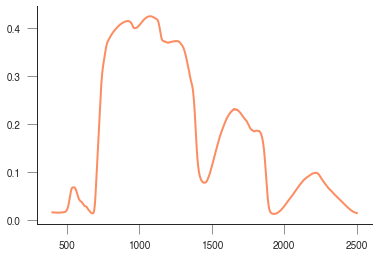

In [2]:
# define the model parameters here for reasonably easy update
n = 1.8
cab = 37.
car = 8.
cbrown = 0.3
cw = 0.013
cm = 0.005
lai = 3
lidfa = 45.

# run the model forward. rsoil0 is the soil albedo array
# assuming black soil
rho = prosail.run_prosail(n, cab, car, cbrown, cw, cm, lai, lidfa, 
                    0.01, 30., 0., 0.,
                    prospect_version='D',
                    rsoil0=np.zeros(2101))

# plot to check it looks sensible
wv = np.arange(400, 2501)
_ = plt.plot(wv, rho)



OK, so we see the strong absorption in the PAR region (400-700 nm), the strong green peak due to chlorophyll, the sharp rise towards the NIR plateau and the water absorption bands around 1500 and 2000 nm. So a bog standard vegetation spectrum, within the limits of the PROSAIL model we used to simulate it. You should already be very familiar with this.

### Simulating Sentinel2 data

Let's simulate something more realistic: some S2A observations. To this end, we need the spectral response functions (SRFs) for the sensor. We'll only select the 10 and 20m bands, as the 60m bands are mostly for cirrus or atmospheric correction.

As part of the simulation, we'll add some Gaussian additive noise to the data. We assume there's no bias in the noise, and that the variance is around 10% of the reflectance value.

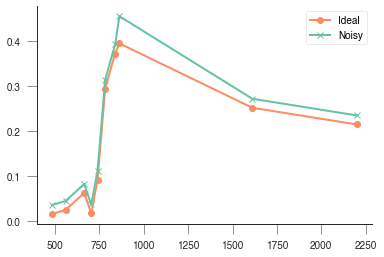

In [3]:
# Process the S2A spectral response functions into something useable
srf = np.loadtxt("data/S2A_SRS.csv", skiprows=1, delimiter=",")[100:, :]
srf[:, 1:] = srf[:, 1:]/np.sum(srf[:, 1:], axis=0)
srf_land = srf[:, [1, 2, 3, 4, 5, 6, 7, 8, 11, 12]]
wv_land = np.array([486.0, 560.5, 665.0, 704.5, 740.0, 783.0,
                    838.84, 863.25, 1610.5, 2199.0])

# Apply the SRF to the data simulated above
# Array broadcasting FTW!!!!
rho_s2a = (rho[:, None]*srf_land).sum(axis=0)

# Add some grotty noise
nn = np.clip(rho_s2a*0.1*np.random.randn(10), 0.01, None, 
                                  )
rho_s2a_noise = rho_s2a + np.clip(rho_s2a*0.1*np
                                  .random.randn(10), 0.02, None, )

# Plot stuff
plt.plot( wv_land, rho_s2a, 'o-', label="Ideal")
plt.plot( wv_land, rho_s2a_noise, '-x', label="Noisy")
plt.legend(loc="best")


So we see that the noise variance scales with reflectance here (so the NIR plateau has a larger "noise" than the visible region). This is (maybe) a realistic observation. 

Out of interest, here's a nice and interesting example I got running this earlier. Since the noise I'm adding is random, I'm showing you the actual spectra here for fun:

![Spektrum des Grauens](./example_spectra.png)

## Retrieving parameters: fun for the whole family

We can try to do a simple retrieval. Let's retrieve just two parameters: LAI and $C_{ab}$ (leaf chlorophyll content) from this data. We'll use a Metropolis-Hastings MCMC sampler to do this. Basically, we construct a log-likelihood (formally, a log-posterior, but we'll get to that later), and use the sampler to minimise this function. We have also added a rule that if the parameter goes outside some sanity bounds, the log-likelihood is infinity (so that these potential values are always excluded). 



**The following snippet takes a while to run**

<div class="alert alert-block alert-warning">
    <strong>This is not  how you do MCMC experiments!</strong>

We're just using a simple MH sampler to explore parameter space. We're not doing any heavy duty analysis on this, and hence not considering absolutely critical things such as chain convergence, thinning or burn in. 
</div>

In [4]:
def logpdf (x):
    """Log likelihood. Takes a 2 element vector. First element is leaf 
    chlorophyll, second is LAI."""
    # Reject parameters that fall outside sensible bounds. We
    # have to do this in case e.g. LAI or Cab go -ve, as PROSAIL's 
    # behaviour is  undocumented if  that happens
    
    if x[1] < 0 or x[1] > 10:
        return np.inf
    if x[0] < 0 or x[0] > 200:
        return np.inf
    # In this case, we use the same values for the non-inverted parameters
    # that were used for the creation of the data
    
    rho = prosail.run_prosail(n, x[0], car, cbrown, cw, cm, x[1], lidfa, 
                    0.01, 30., 0., 0.,
                    prospect_version='D',
                    rsoil0=np.zeros(2101))
    # Apply SRFs
    rho_pred = (rho[:, None]*srf_land).sum(axis=0)
    # Residual predicted - measrued
    xx = rho_pred - rho_s2a_noise
    # Figure out noise. 
    sigma_obs = rho_s2a*0.1
    # Return the log-likelihood
    return -(0.5*xx**2/sigma_obs**2).sum()


# Set up an initial value for the metropolisH chain. Far away from the truth
initial_value = [15., 1]

# Select iteration
# If this takes too long, reduce this number, but I don't think you want to 
# go below 5000 or so
n_iterations = 10000

# Run the sampler from the start of the chain, for the required number
# of iterations
vals = list(generate_samples(initial_value, n_iterations, logpdf))



Let's see the MH walk. The green dot shows the initial value $(15, 1)$, and we see how the orange line drifts away towards the truth (remember that this was $(37, 3)$). The dense sampling around the fur ball suggests that the log-likelihood has a fairly flat bottom between chlorophyl 30 to 50 and LAI 2 and 4.5 (say). The blue dot is the last point of our travels, and the cross-hairs are the "true solution".

Text(0, 0.5, 'LAI')

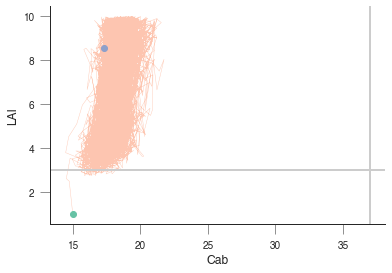

In [5]:
x, y = np.array(vals).T
plt.plot(x, y, '-', lw=0.4, alpha=0.5)
plt.plot(x[0], y[0], 'o')
plt.plot(x[-1], y[-1], 'o')
plt.axhline(lai, c="0.8")
plt.axvline(cab, c="0.8")
plt.xlabel("Cab")
plt.ylabel("LAI")

We can plot this as a kernel density estimator. We now see that the best solution (darkest red) is quite close to the true minimum, but the contour lines around it indicate plausible solutions given the uncertainty. The marginal pdfs tell us something about the possible ranges of the retrieved parameters. And the plot is very pretty too.

/home/ucfajlg/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


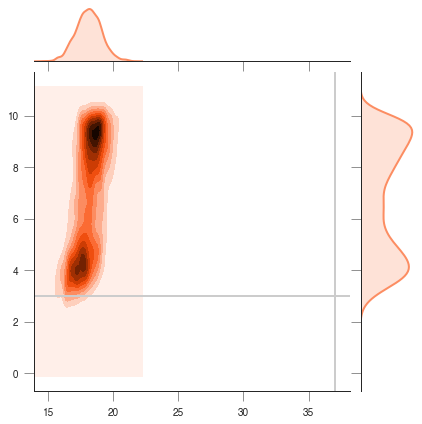

In [6]:
x, y = np.array(vals).T
L=sns.jointplot(x=x, y=y, kind='kde')
L.ax_joint.axhline(lai, c="0.8")
L.ax_joint.axvline(cab, c="0.8")

The previous example is a sanity-check: we used the same model to produce the observations and to retrieve the data, the uncertainty was well characterised... But in reality, you can see that in `logpdf` we fixed all parameters to the true values except LAI and $C_{ab}$. So it's a bit cheating ;-/

Since I don't know what you're going to get (remember we added random noise!), I'm putting the solution that I got for my example above, and will rant about it

![Example solution](./example_solution.png)

In my example solution, it appears that LAI is underestimated. Oh dear, we have excellent spectral sampling, a perfect model, and just a bit of additive noise (remember that you'll get this from gridding, atmospheric correction, ...), and already we have issues with retrieving **two parameter**. Not cool.

Or maybe you got a smashing retrieval? It could happen, because the noise I added on my example and the one you're adding are different (same statistical properties, different actual realisation of the process). If that's the case, that means that **the solution** is very sensitive to the particular noise added: it's unstable, and this is one of the tell-tale signs of ill-posedness. 

## Being a bit more realistic

### The model is wrong

What would happen if we got one of the parameters wrong? For example, if the brown pigment was higher than the real one. This means that the model will struggle to interpret the observed signal just by changing LAI and chlorophyll. We can run the same example below and see what comes out of it.

But think that *the model will always be wrong*. 

In [7]:
def logpdf (x):
    if x[1] < 0 or x[1] > 10:
        return np.inf
    if x[0] < 0 or x[0] > 200:
        return np.inf
    rho = prosail.run_prosail(n, x[0], car, 0.9, cw, cm, x[1], lidfa, 
                    0.01, 30., 0., 0.,
                    prospect_version='D',
                    rsoil0=np.zeros(2101))
    rho_pred = (rho[:, None]*srf_land).sum(axis=0)
    xx = rho_pred - rho_s2a_noise
    sigma_obs = rho_s2a*0.1
    
    return -(0.5*xx**2/sigma_obs**2).sum()

initial_value = [15., 1]
n_iterations = 10000

vals = list(generate_samples(initial_value, n_iterations, logpdf))


/home/ucfajlg/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


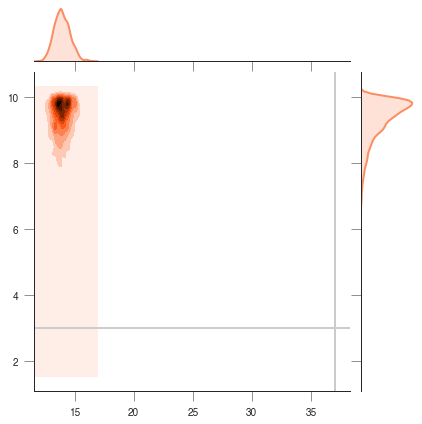

In [8]:
x, y = np.array(vals).T

L=sns.jointplot(x=x, y=y, kind='kde')
L.ax_joint.axhline(lai, c="0.8")
L.ax_joint.axvline(cab, c="0.8")

In this case, you can get all sorts of funky results, it's up to you to interpret them critically.

The offshoot of this is that you can't win in this game... But remember: now **the model we use to interpret the observations is WRONG**. This means that there is an inconsistency between the process that generates the data and the process that inverts the model. In reality, since all models are approximations to reality, this will always be the case. In some cases, the error will be small as not to cause problems, or it may be large enough to wreak havoc in the inversion.

Try setting Cbrown to 0.05 (by default it was 0.3), and check the effect!

### Wrong statistical model
So we've seen that so-called "model error" can have pretty dramatic results in what ought to be a simple problem. What happens if the person who's collected the data tells us that the uncertainty is different to the real uncertainty? We assumed above that the uncertainty was around 10% of the signal. Let's say that this person tells us that it's around 3% (it's easy to get confused with standard deviations and variances and $\sqrt(10)\sim3$. Happens to the best of us)

In [9]:
def logpdf (x):
    if x[1] < 0 or x[1] > 10:
        return np.inf
    if x[0] < 0 or x[0] > 200:
        return np.inf
    rho = prosail.run_prosail(n, x[0], car, cbrown, cw, cm, x[1], lidfa, 
                    0.01, 30., 0., 0.,
                    prospect_version='D',
                    rsoil0=np.zeros(2101))
    rho_pred = (rho[:, None]*srf_land).sum(axis=0)
    xx = rho_pred - rho_s2a_noise
    sigma_obs = 0.03##rho_s2a*0.03

    return -(0.5*xx**2/sigma_obs**2).sum()


initial_value = [15., 1]
n_iterations = 10000

vals = list(generate_samples(initial_value, n_iterations, logpdf))



/home/ucfajlg/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


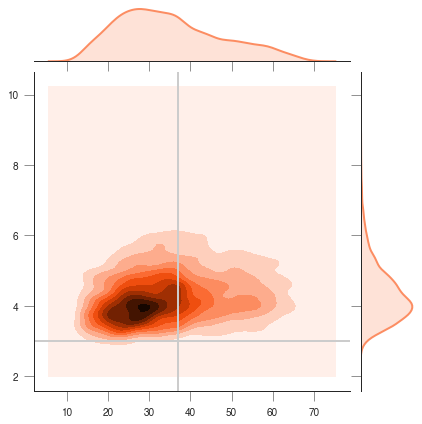

In [10]:
x, y = np.array(vals).T

L=sns.jointplot(x=x, y=y, kind='kde')
L.ax_joint.axhline(lai, c="0.8")
L.ax_joint.axvline(cab, c="0.8")

Groan... So we have a multi-modal distribution of leaf chlorophyll that spans more or less the whole range, an underestimation of LAI, ... 

## What have we learned

OK, so we've done some quick'n'dirty experiments exploring if you want the error surface of a simple retrieval. We've found that even in the most favourable conditions (synthetic experiment, everything is properly defined), sometimes we'll struggle with retrieving the "true answer". We also saw that the model will be wrong, and that the statistical definition of the problem might also be wrong. These problem arise by the limited information content of the observations: there isn't that much information as one would have thought, and this means that we can't reconstruct the truth when we add a sprinkle of noise.

In a next chapter, we'll look at how we can supplement observations with (hopefully) not very polemic information, so that the retrievals become more robust.



<a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/"><img alt="Creative Commons Licence" style="border-width:0" src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/">Creative Commons Attribution-NonCommercial 4.0 International License</a>.